In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)  

# Read in dataset

In [2]:
crime = pd.read_csv('data/crime/crime.csv', low_memory=False)
crime.head()

,IncidentNum,ReportedDateTime,ReportedYear,ReportedMonth,Location,WeaponUsed,ALD,NSP,POLICE,TRACT,WARD,ZIP,RoughX,RoughY,Arson,AssaultOffense,Burglary,CriminalDamage,Homicide,LockedVehicle,Robbery,SexOffense,Theft,VehicleTheft,Total,Violent,Property
0,163020125,2016-10-28 19:55:00,2016,10,S 10TH ST / W GRANT ST,ROCK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,2.0,0,2.0
1,163020126,2016-10-28 19:03:00,2016,10,7822 W CAPITOL DR,UNKNO,5.0,NaN,7.0,3400.0,75.0,53222.0,2531617.227,403569.625,0,0,0,1,0,0,0,0,0,0,2.0,0,2.0
2,163020129,2016-10-25 21:00:00,2016,10,6501 W OHIO AV,UNKNO,11.0,NaN,6.0,19800.0,268.0,53219.0,2536921.027,365361.083,0,0,0,0,0,1,0,0,0,0,2.0,0,2.0
3,163020130,2016-10-28 19:20:00,2016,10,2700 W KILBOURN AV,KNIFE,4.0,14.0,3.0,13600.0,199.0,53208.0,2548621.346,386390.229,0,1,0,0,0,0,1,0,0,0,4.0,2,2.0
4,163020131,2016-10-28 02:30:00,2016,10,3212 N 3RD ST,UNKNO,6.0,6.0,5.0,7000.0,122.0,53212.0,2557328.086,399243.551,0,0,0,0,0,0,0,0,0,1,2.0,0,2.0


In [3]:
### set date as datetime
crime.ReportedDateTime = pd.to_datetime(crime.ReportedDateTime)

# Quick look at overall crime breakdowns

In [4]:
### We'll just look at counts since 2020
pd.DataFrame(crime[crime.ReportedDateTime>='2020-01-01'].iloc[:, -13:-3].sum(),
            columns=['Count']).sort_values(by='Count', ascending=False).T

,AssaultOffense,VehicleTheft,Theft,CriminalDamage,LockedVehicle,Burglary,Robbery,SexOffense,Arson,Homicide
Count,20126,9051,7565,6897,5477,4577,3024,939,387,259


# Start with historical trends dating back to 2005

In [5]:
crime_week = crime.set_index('ReportedDateTime').resample('W').sum().iloc[:,-13:]
crime_month = crime.set_index('ReportedDateTime').resample('MS').sum().iloc[:,-13:]
crime_quarter = crime.set_index('ReportedDateTime').resample('QS').sum().iloc[:,-13:]
crime_year = crime.set_index('ReportedDateTime').resample('YS').sum().iloc[:,-13:]

crime_month.head()

,Arson,AssaultOffense,Burglary,CriminalDamage,Homicide,LockedVehicle,Robbery,SexOffense,Theft,VehicleTheft,Total,Violent,Property
ReportedDateTime,,,,,,,,,,,,,
2005-01-01,16,449,343,497,6,398,222,84,971,519,3489.0,761,2728.0
2005-02-01,15,450,260,533,8,416,149,80,1108,455,3459.0,687,2772.0
2005-03-01,14,542,329,722,5,376,160,74,1358,560,4126.0,781,3345.0
2005-04-01,22,618,321,865,13,342,188,100,1513,515,4475.0,919,3556.0
2005-05-01,24,801,440,983,13,317,259,100,1759,526,5198.0,1173,4025.0


Thes charts breaking out the data by year exclude the partial year of 2021, but wee can clearly see that the historic drop in overall crime from 2007 on is really just a drop in property crime. Violent crime seems to have been gradually rising since 2011.

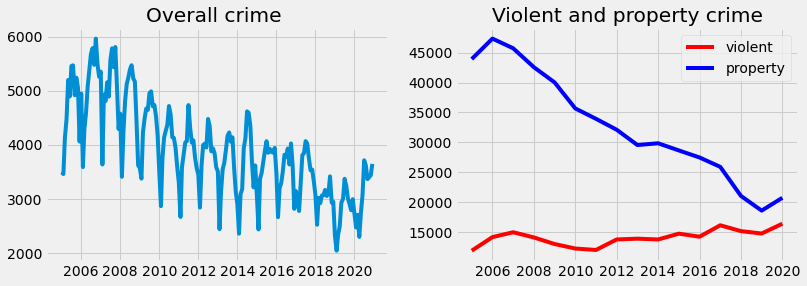

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(crime_month[:'2020'].Total)
plt.title('Overall crime ')

plt.subplot(1,2,2)
plt.plot(crime_year[:'2020'].Violent, color='red', label='violent')
plt.plot(crime_year[:'2020'].Property, color='blue', label='property')
plt.legend(loc='upper right')
plt.title('Violent and property crime')
plt.show()

Let's look more closely that the crime categories within violent crimes. Looks like assaults and homicides have risen and sex offenses and robberies have declined.

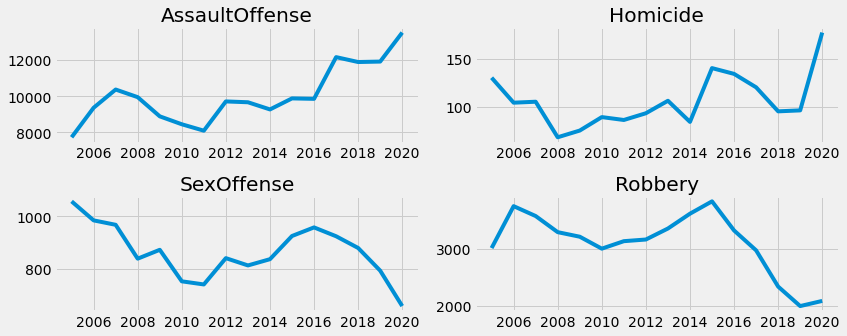

In [7]:
violent_crimes = ['AssaultOffense', 'Homicide', 'SexOffense', 'Robbery']

plt.figure(figsize=(12, 7))

for i, crime in enumerate(violent_crimes):
    plt.subplot(3,2,i+1)
    plt.plot(crime_year[:'2020'][crime]); plt.title(crime)

plt.tight_layout(); plt.show()

Let's look more closely that the crime categories within property crimes. With the exception of arson, numbers have pretty much declined across the board (though vehicle thefts spiked in 2014-15 before falling again)

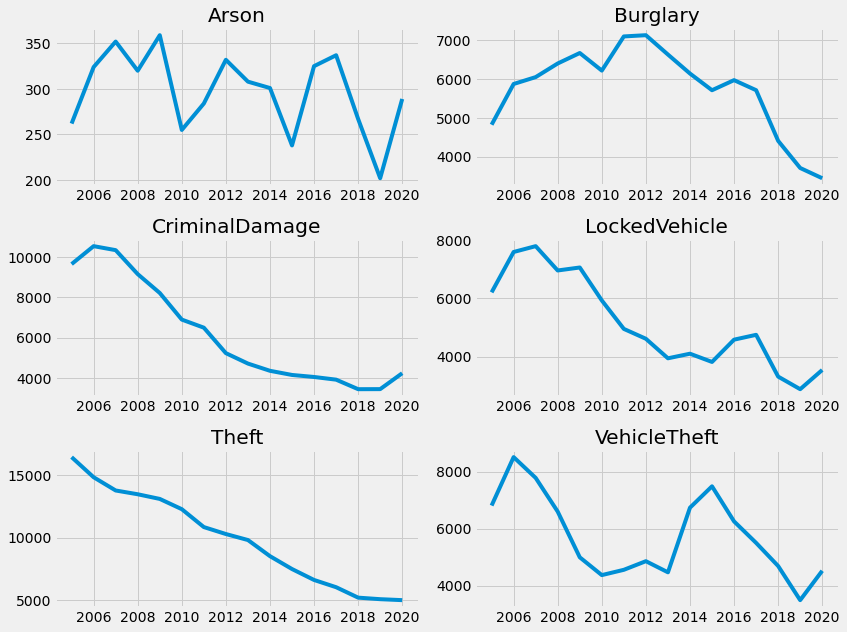

In [8]:
prop_crimes = ['Arson', 'Burglary', 'CriminalDamage',
               'LockedVehicle', 'Theft', 'VehicleTheft']

plt.figure(figsize=(12, 9))
for i, crime in enumerate(prop_crimes):
    plt.subplot(3,2,i+1)
    plt.plot(crime_year[:'2020'][crime]); plt.title(crime)

plt.tight_layout(); plt.show()

# Recent trends

Ultimately, I'm interested in how things have or have not shifted since the pandemic began in early 2021 (and was followed by protests after George Flody's death), so I'll zoom in on the last few years worth of data, grouped by month

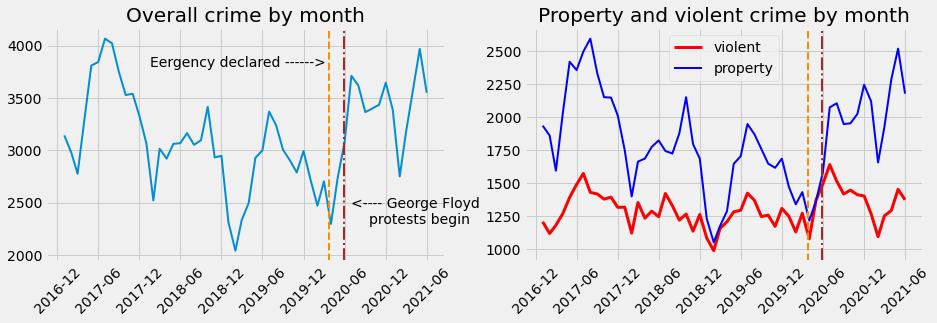

In [9]:
import datetime as dt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
line, = ax1.plot(crime_month['2017':'2021-06-30'].Total, lw=2)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
ax1.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
ax1.annotate('Eergency declared ------>', (dt.datetime(2018, 1, 15), 3800))
ax1.annotate('<---- George Floyd\n    protests begin', (dt.datetime(2020, 7, 1), 2300))
ax1.set_title('Overall crime by month'); ax1.tick_params(axis='x', rotation=45)

ax2.plot(crime_month['2017':'2021-06-30'].Violent, color='red', label='violent', lw=3)
ax2.plot(crime_month['2017':'2021-06-30'].Property, color='blue', label='property', lw=2)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax2.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
ax2.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
ax2.legend()
ax2.set_title('Property and violent crime by month'); ax2.tick_params(axis='x', rotation=45)
plt.show()

How does the seasonally differenced data appear? Maybe less intuitive to interpret, but demonstrates the trend of graduatlly rising crime that appears to have been taking place prior to the start of the pandemic.

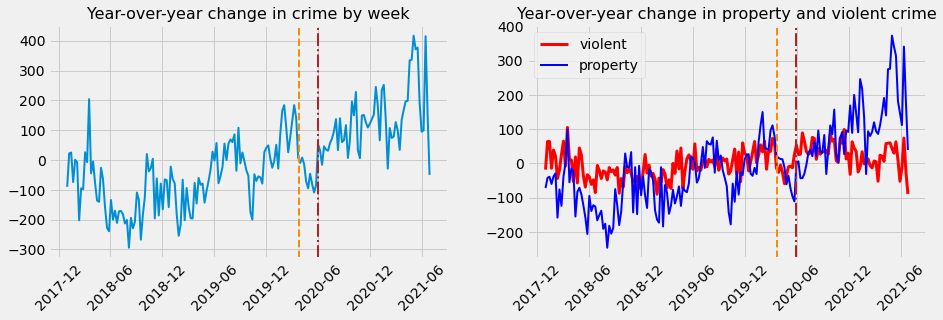

In [10]:
import datetime as dt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
line, = ax1.plot(crime_week['2017':'2021-06-30'].Total.diff(52), lw=2)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
ax1.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
ax1.set_title('Year-over-year change in crime by week', fontsize=16)
ax1.tick_params(axis='x', rotation=45)

ax2.plot(crime_week['2017':'2021-06-30'].Violent.diff(52), color='red', label='violent', lw=3)
ax2.plot(crime_week['2017':'2021-06-30'].Property.diff(52), color='blue', label='property', lw=2)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax2.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
ax2.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
ax2.legend()
ax2.set_title('Year-over-year change in property and violent crime', fontsize=16)
ax2.tick_params(axis='x', rotation=45)
plt.show()

Again, but by week.

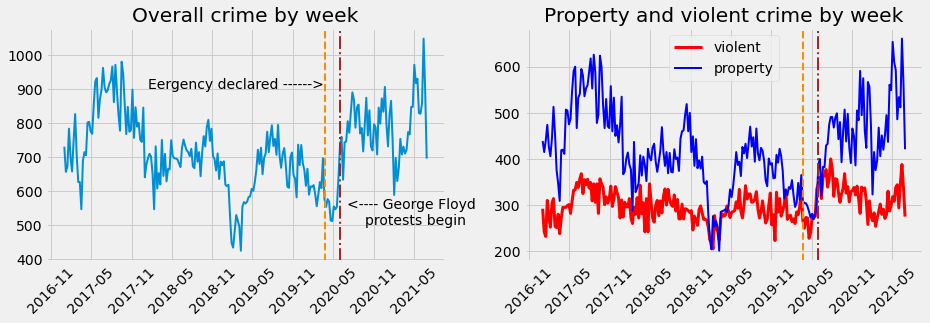

In [11]:
import datetime as dt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
line, = ax1.plot(crime_week['2017':'2021-06-30'].Total, lw=2)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
ax1.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
ax1.annotate('Eergency declared ------>', (dt.datetime(2018, 1, 15), 900))
ax1.annotate('<---- George Floyd\n    protests begin', (dt.datetime(2020, 7, 1), 500))
ax1.set_title('Overall crime by week'); ax1.tick_params(axis='x', rotation=45)

ax2.plot(crime_week['2017':'2021-06-30'].Violent, color='red', label='violent', lw=3)
ax2.plot(crime_week['2017':'2021-06-30'].Property, color='blue', label='property', lw=2)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax2.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
ax2.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
ax2.legend()
ax2.set_title('Property and violent crime by week'); ax2.tick_params(axis='x', rotation=45)
plt.show()

Let's make the same plot, but broken out by specific violent crimes. Can see that homicides and assaults really spiked in summer 2020.

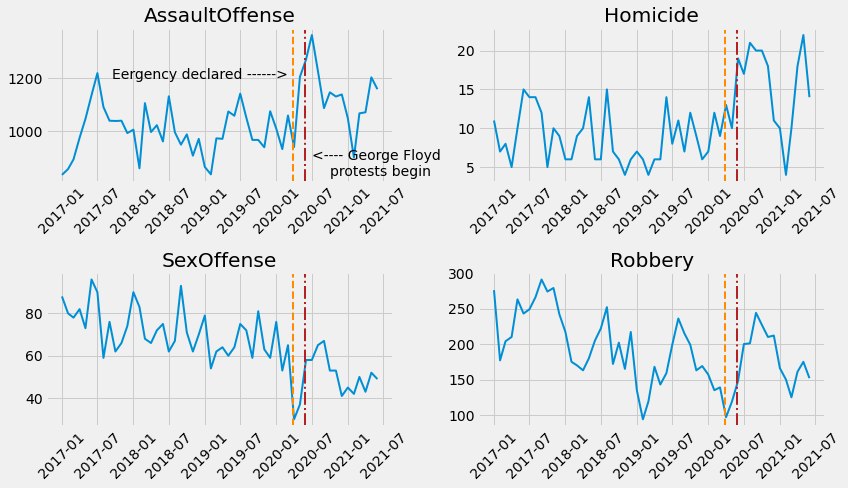

In [12]:
plt.figure(figsize=(12, 7))

for i, crime in enumerate(violent_crimes):
    ax = plt.subplot(2,2,i+1)
    if i ==0:
        ax.annotate('Eergency declared ------>', (dt.datetime(2017, 9, 15), 1200))
        ax.annotate('<---- George Floyd\n    protests begin', (dt.datetime(2020, 7, 1), 830))
    plt.plot(crime_month['2017':'2021-06'][crime], lw=2); plt.title(crime)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
    plt.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
    plt.xticks(rotation=45)

plt.tight_layout(); plt.show()

The jump in car breakins and thefts is pretty remarkable.

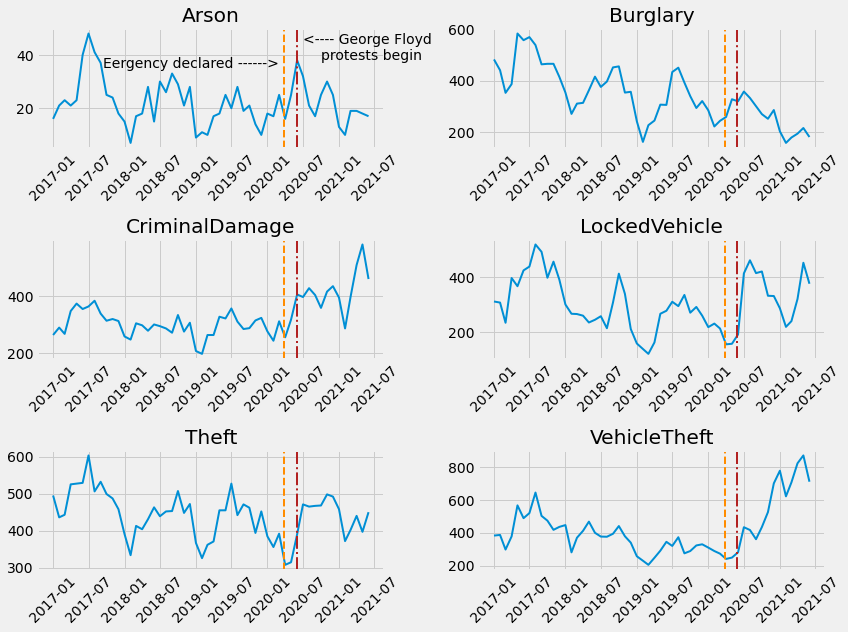

In [13]:
plt.figure(figsize=(12, 9))

for i, crime in enumerate(prop_crimes):
    ax = plt.subplot(3,2,i+1)
    if i ==0:
        ax.annotate('Eergency declared ------>', (dt.datetime(2017, 9, 15), 35))
        ax.annotate('<---- George Floyd\n    protests begin', (dt.datetime(2020, 7, 1), 38))
    plt.plot(crime_month['2017':'2021-06'][crime], lw=2); plt.title(crime)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
    plt.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
    plt.xticks(rotation=45)

plt.tight_layout(); plt.show()

**Let's see if there's a better way to visualize historical trends for a handful of crime types**

In [14]:
### create col for rolling homicides
crime_month['Homicide_avg'] = crime_month.Homicide.rolling(window=12).mean()
crime_month['Assault_avg'] = crime_month.AssaultOffense.rolling(window=12).mean()
crime_month['Auto_theft_avg'] = crime_month.VehicleTheft.rolling(window=12).mean()
crime_month = crime_month.reset_index()

In [15]:
crime_month = crime_month[crime_month.ReportedDateTime<='2021-06-30']

In [16]:
values = crime_month.ReportedDateTime.astype(str).str.slice(0,4)
xticks = list(range(1, len(values)+1))

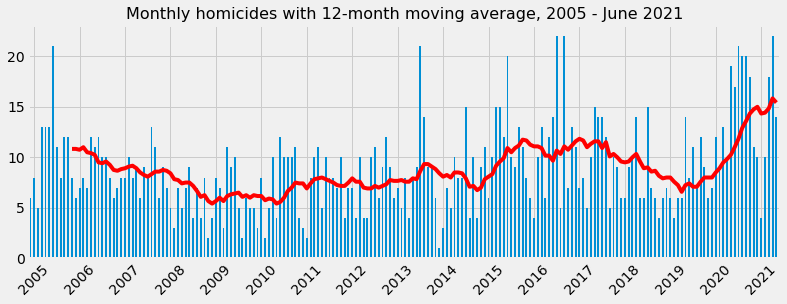

In [17]:
fig = plt.figure(figsize=(12,4))
ax = crime_month.Homicide_avg.plot(x='ReportedDateTime', c='red')
crime_month.Homicide.plot(x='ReportedDateTime', kind='bar', ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.title('Monthly homicides with 12-month moving average, 2005 - June 2021', fontsize=16)
plt.xticks(xticks, values, rotation=45)
plt.locator_params(axis='x', nbins=17)
plt.show()

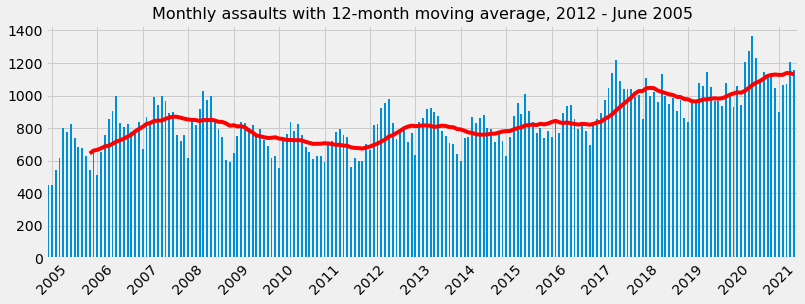

In [18]:
fig = plt.figure(figsize=(12,4))
ax = crime_month.Assault_avg.plot(x='ReportedDateTime', c='red')
crime_month.AssaultOffense.plot(x='ReportedDateTime', kind='bar', ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.title('Monthly assaults with 12-month moving average, 2012 - June 2005', fontsize=16)
plt.xticks(xticks, values, rotation=45)
plt.locator_params(axis='x', nbins=17)
plt.show()

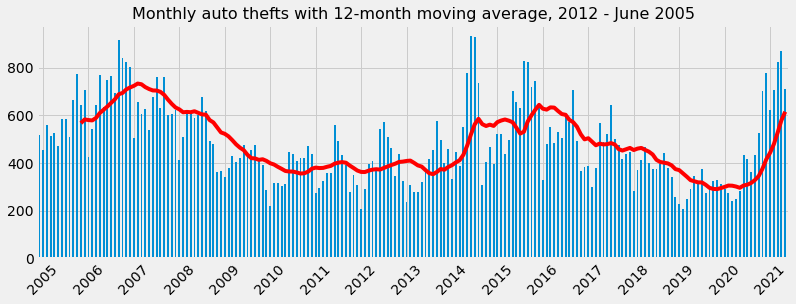

In [19]:
fig = plt.figure(figsize=(12,4))
ax = crime_month.Auto_theft_avg.plot(x='ReportedDateTime', c='red')
crime_month.VehicleTheft.plot(x='ReportedDateTime', kind='bar', ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.title('Monthly auto thefts with 12-month moving average, 2012 - June 2005', fontsize=16)
plt.xticks(xticks, values, rotation=45)
plt.locator_params(axis='x', nbins=17)
plt.show()